# Credit Card Default Prediction
This is a binary classification problem predicting credit card defaults for 30,000 customers in Taiwan. The dataset has 24 features, including demographics, credit limits, and 6 months of payment history.
The dataset is imbalanced (~22% default rate vs 78% non-default), which will require special handling. There are no missing values, making it relatively clean. The temporal payment history features (PAY_0 through PAY_6) are likely to be the strongest predictors since past payment behavior typically indicates future default risk.
For solving the problem in this dataset, we need to handling class imbalance, selecting appropriate evaluation metrics beyond accuracy (AUC-ROC, F1-score), and balancing the business cost of false negatives (missing defaulters) versus false positives (incorrectly flagging good customers).The dataset that will be used is from Kaggle (https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset).  

In [7]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.inspection import permutation_importance

## Data Splitting

In [10]:
credit_df = pd.read_csv("UCI_Credit_Card.csv")

In [12]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [13]:
X = credit_df.drop(columns=['ID', 'default.payment.next.month'])
y = credit_df['default.payment.next.month']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

## Exploratory Data Analysis

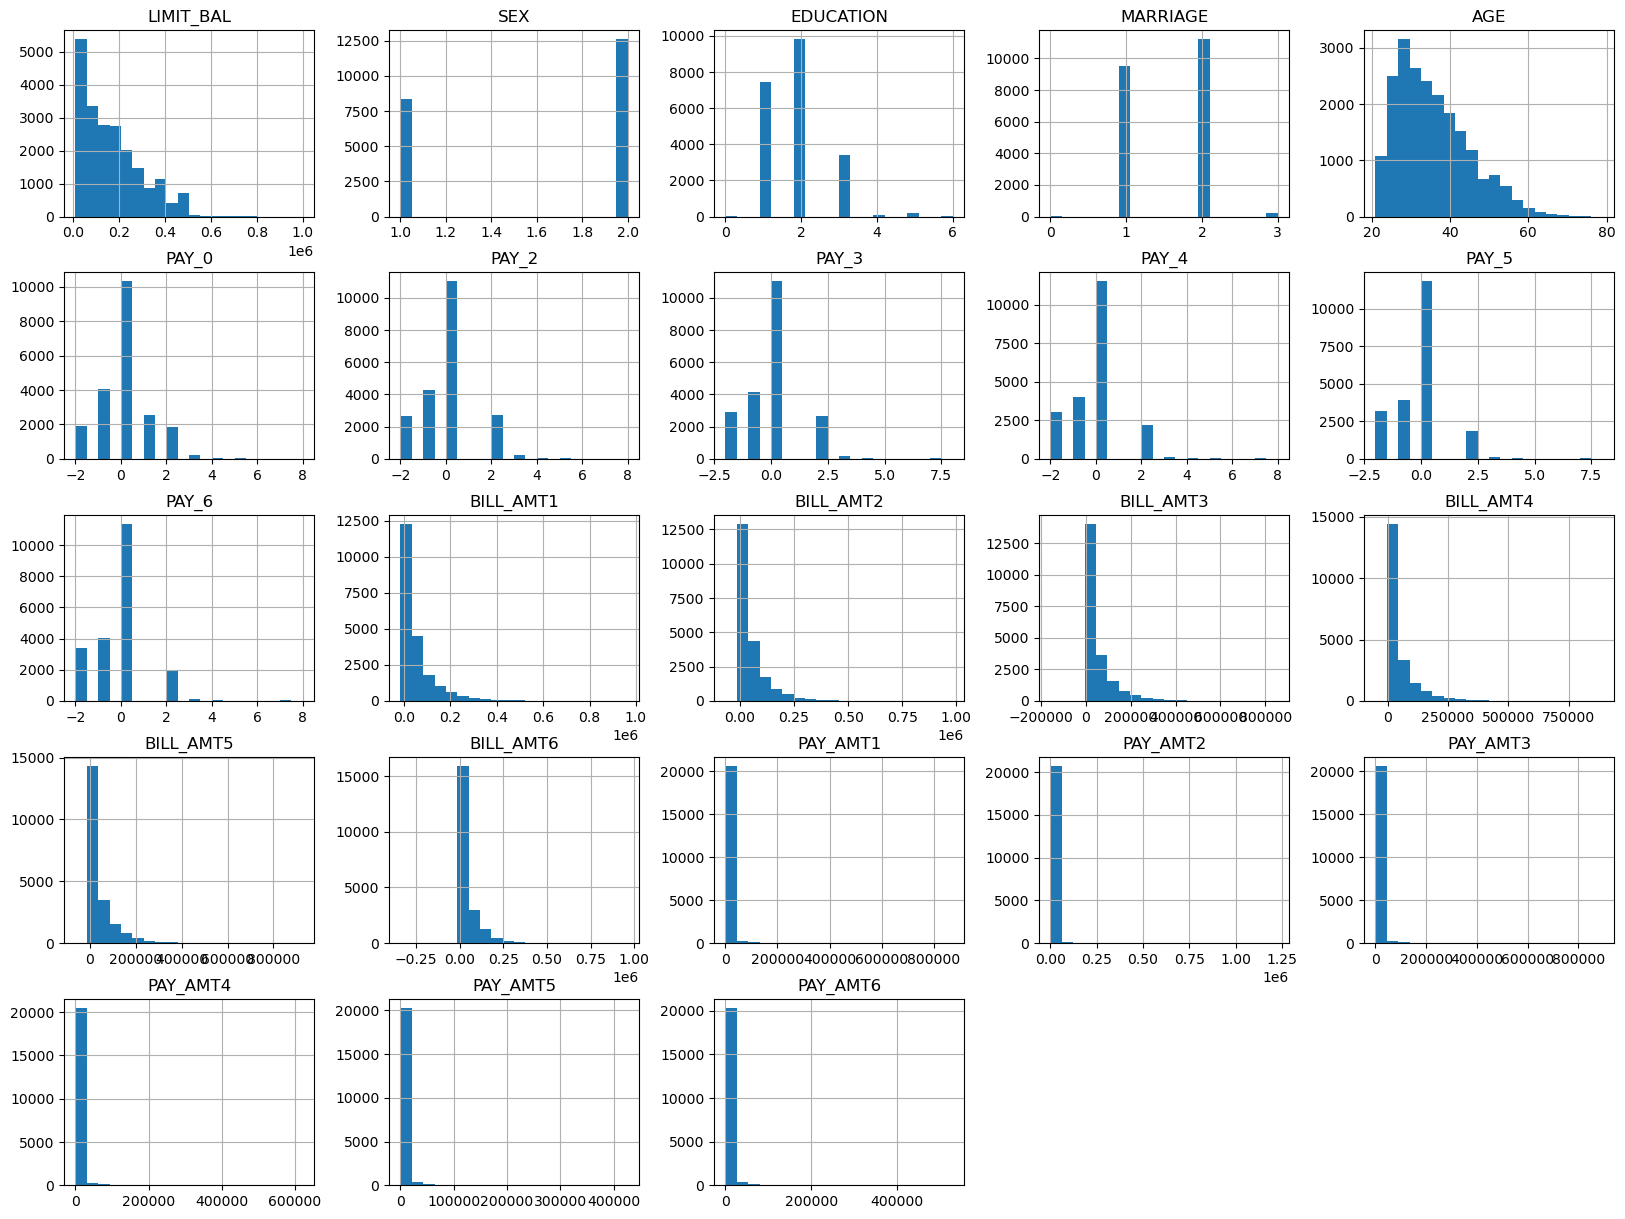

In [15]:
X_train.hist(bins=20, figsize=(20, 15));

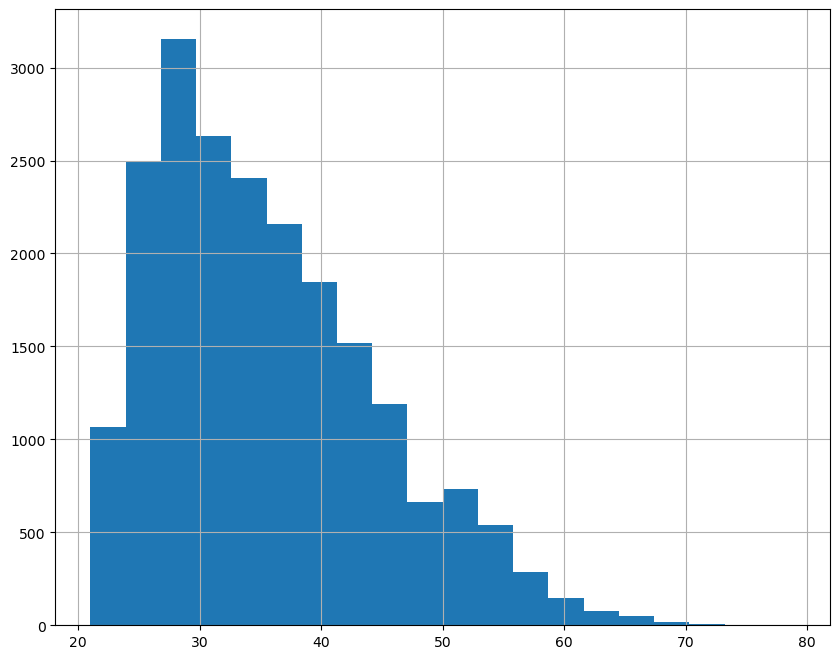

In [16]:
# Age distribution of customer
X_train['AGE'].hist(bins=20, figsize=(10, 8));

The age distribution shows a right-skewed pattern with peak concentration in the 25-35 age range, indicating the credit card service primarily attracts younger working professionals who are establishing their financial profiles.

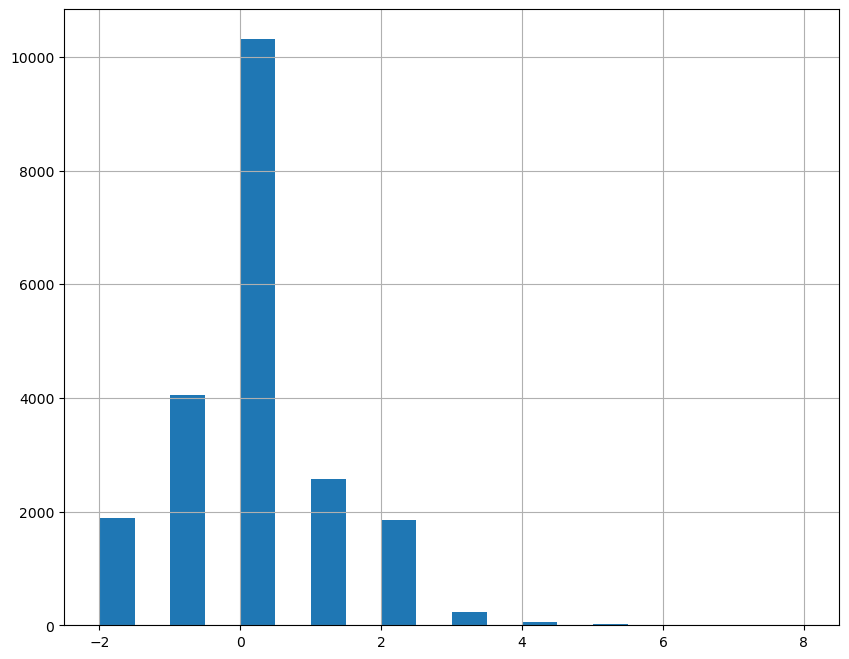

In [17]:
X_train['PAY_0'].hist(bins=20, figsize=(10, 8));

The overwhelming majority of customers have payment status of 0 or -1 (paid on time or paid in full), but the presence of delayed payment categories (1-8) reveals a subset of at-risk customers that warrant closer monitoring for default prediction.

In [18]:
X_train['MARRIAGE'].value_counts()

MARRIAGE
2    11210
1     9527
3      229
0       34
Name: count, dtype: int64

In [19]:
X_train['EDUCATION'].value_counts()

EDUCATION
2    9815
1    7433
3    3416
5     210
4      81
6      35
0      10
Name: count, dtype: int64

In [20]:
X_train['SEX'].value_counts()

SEX
2    12616
1     8384
Name: count, dtype: int64

**Initial Observation**

Dataset has 30,000 observations with demographic and financial variables and  all categorical variables pre-encoded (SEX, EDUCATION, MARRIAGE). Data is NOT standardized - raw values preserved across all numerical variables

However, there are consistent Temporal Patterns for all three time-series variable groups show identical distribution patterns across all 6 months:

- Repayment Status (PAY_0 to PAY_6): Consistent payment behavior over time
- Bill Amounts (BILL_AMT1 to BILL_AMT6): Stable billing patterns
- Payment Amounts (PAY_AMT1 to PAY_AMT6): Consistent payment patterns

This indicates customer financial behavior is stable with no major trends or seasonal effects.

For some variables such as AGE, LIMIT_BAL, all bill amounts, and payment amounts, they have strongly right-skewness when most customers cluster at lower values with few extreme outliers

Also, different ranges across variable types: MARRIAGE (1-3) vs LIMIT_BAL (0-1,000,000+) and different ranges within same variable types: PAY_1, PAY_2, etc. each show different numerical ranges
Not standardized/normalized

There are some implications for Modeling:

- Standardization/scaling required before modeling
- Log transformation may help with skewed financial variables
- Feature engineering opportunities from temporal consistency (averages, trends, ratios)
- Outlier treatment needed for bill and payment amounts
- Class imbalance likely in target variable (credit default prediction)

**Appropriate Metrics**

The primary metric is F1-score because it balances precision and recall, which is crucial when both false positives and false negatives have costs. This also handles class imbalance well - expected in default prediction (fewer defaulters than non-defaulters)
- False Negative (missing a defaulter) = financial loss for the lender
- False Positive (rejecting good customer) = lost business opportunity

Our secondary metric is ROC-AUC (Area Under the ROC Curve), as it is threshold-independent and evaluates model performance across all classification thresholds. Also, it is robust to class imbalance, focuses on ranking ability, and is useful for comparing different models objectively. Moreover, it allows businesses to adjust the decision threshold based on risk tolerance
and values closer to 1.0 indicate better discrimination between classes

## Feature Engineering

In [21]:
# 1. Utilization Features

# Average bill amount across 6 months
X_train['AVG_BILL_AMT'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                           'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
X_test['AVG_BILL_AMT'] = X_test[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                           'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
# Average payment amount across 6 months
X_train['AVG_PAY_AMT'] = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 
                          'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
X_test['AVG_PAY_AMT'] = X_test[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 
                          'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)

# Credit utilization rate (average bill / credit limit)
X_train['UTILIZATION_RATE'] = X_train['AVG_BILL_AMT'] / (X_train['LIMIT_BAL'] + 1)  
X_test['UTILIZATION_RATE'] = X_test['AVG_BILL_AMT'] / (X_test['LIMIT_BAL'] + 1) 
# Maximum bill amount (peak debt)
X_train['MAX_BILL_AMT'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                           'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)
X_test['MAX_BILL_AMT'] = X_test[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                           'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)

# 2. Payment Behavior Features
# Payment patterns indicate financial responsibility

# Average repayment status (higher = worse payment history)
X_train['AVG_PAY_STATUS'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 
                             'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)
X_test['AVG_PAY_STATUS'] = X_test[['PAY_0', 'PAY_2', 'PAY_3', 
                             'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)

# Maximum delay in payment (worst payment month)
X_train['MAX_PAY_STATUS'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 
                             'PAY_4', 'PAY_5', 'PAY_6']].max(axis=1)
X_test['MAX_PAY_STATUS'] = X_test[['PAY_0', 'PAY_2', 'PAY_3', 
                             'PAY_4', 'PAY_5', 'PAY_6']].max(axis=1)

# Count of months with payment delay (PAY_STATUS > 0)
X_train['DELAY_COUNT'] = (X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] > 0).sum(axis=1)
X_test['DELAY_COUNT'] = (X_test[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] > 0).sum(axis=1)

# Payment consistency (standard deviation of payment status - lower is more consistent)
X_train['PAY_CONSISTENCY'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 
                              'PAY_4', 'PAY_5', 'PAY_6']].std(axis=1)
X_test['PAY_CONSISTENCY'] = X_test[['PAY_0', 'PAY_2', 'PAY_3', 
                              'PAY_4', 'PAY_5', 'PAY_6']].std(axis=1)

## Preprocessing and Transformations

| Feature Group                  | Columns                                                          | Type                        | Transformation                      |
| ------------------------------ | ---------------------------------------------------------------- | --------------------------- | ----------------------------------- |
| Numerical                      | `LIMIT_BAL`, `AGE`, `BILL_AMT*`, `PAY_AMT*`, `AVG_BILL_AMT`, `AVG_PAY_AMT`, `UTILIZATION_RATE`, `MAX_BILL_AMT`, `AVG_PAY_STATUS`, `MAX_PAY_STATUS`, `DELAY_COUNT`, `PAY_CONSISTENCY` | Continuous                  | `SimpleImputer` → `StandardScaler`  |
| Categorical (Nominal)          | `SEX`, `MARRIAGE`                                                | Nominal                     | `SimpleImputer` → `OneHotEncoder`   |
| Categorical (Ordinal)          | `EDUCATION`                                                      | Ordered Education Levels    | `OrdinalEncoder` with defined order |
| Categorical (Ordinal Severity) | `PAY_0` to `PAY_6`                                               | Payment delay scale         | `OrdinalEncoder`                    |
| Target                         | `default.payment.next.month`                                     | Binary classification label | No preprocessing                    |

In [22]:
for df in [X_train, X_test]:
    df['SEX'] = df['SEX'].replace(0, 2)
    df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)
    df['EDUCATION'] = df['EDUCATION'].replace(0, 5)

In [23]:
numeric_features = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
    'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6',
    # Engineered features
    'AVG_BILL_AMT', 'AVG_PAY_AMT', 'UTILIZATION_RATE', 'MAX_BILL_AMT',
    'AVG_PAY_STATUS', 'MAX_PAY_STATUS', 'DELAY_COUNT', 'PAY_CONSISTENCY'
]

categorical_nominal_features = ['SEX', 'MARRIAGE']
categorical_ordinal_education = ['EDUCATION']
categorical_ordinal_pay = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

In [24]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_education_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[[1,2,3,4,5,6]]))
])

pay_order = [-1,1,2,3,4,5,6,7,8,9]  
ordinal_pay_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[pay_order]*len(categorical_ordinal_pay),
                              handle_unknown='use_encoded_value',
                              unknown_value=-2))
])

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_nom', categorical_nominal_transformer, categorical_nominal_features),
        ('ord_edu', ordinal_education_transformer, categorical_ordinal_education),
        ('ord_pay', ordinal_pay_transformer, categorical_ordinal_pay)
    ],
    remainder='drop'
)

## Baseline Model

In [26]:
dummy = DummyClassifier()

In [27]:
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)

In [28]:
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.010651,0.001216,0.776905,0.776726
1,0.002208,0.000339,0.776905,0.776726
2,0.001971,0.000294,0.776667,0.776786
3,0.001881,0.000346,0.776667,0.776786
4,0.001958,0.000273,0.776667,0.776786


## Linear Model

In [29]:
lr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])
lr_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10, 100]
}

# Grid search with 5-fold CV
grid_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Best parameters & score
print("Best LR params:", grid_lr.best_params_)
print("Best LR CV accuracy:", grid_lr.best_score_)

Best LR params: {'model__C': 10}
Best LR CV accuracy: 0.8156190476190476


In [31]:
lr_scores = cross_validate(lr_pipeline, X_train, y_train, return_train_score=True)
pd.DataFrame(lr_scores)

,fit_time,score_time,test_score,train_score
0,0.078287,0.006185,0.812857,0.817262
1,0.060675,0.006074,0.815952,0.814702
2,0.059963,0.004812,0.819048,0.814464
3,0.058581,0.011470,0.816905,0.814048
4,0.060076,0.005447,0.812857,0.815655


In [32]:
pd.DataFrame(lr_scores).mean()

fit_time       0.063516
score_time     0.006798
test_score     0.815524
train_score    0.815226
dtype: float64

In [33]:
cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Logistic Regression CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Logistic Regression CV Accuracy: 0.8155 ± 0.0024


**Summary of the Linear model**

The linear model is well-balanced and slightly underfit; its fit and score times are very fast. The best regularization parameter C=10 indicates that weaker regularization improves model performance, allowing larger coefficients for features like utilization rate and repayment patterns. The model has a low standard deviation of 0.0024, indicating highly consistent performance across different folds, which generalizes well to unseen data. Also, the engineered features meaningfully contribute to the predictive power of the model.

Thus, Logistic Regression with C=10 serves as a strong baseline, achieving ~81.5% CV accuracy with very low variance. It's stable, interpretable, and benefits from the carefully engineered features.

## Non-Linear Model
**KNN, SVM, Random Forest**

In [34]:
knn_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

svm_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', SVC(kernel='rbf', C=1.0, gamma=0.1, random_state=123))
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=123))
])

In [35]:
# KNN cross validation scores
knn_scores = cross_validate(knn_pipeline, X_train, y_train, return_train_score=True)
pd.DataFrame(knn_scores)

,fit_time,score_time,test_score,train_score
0,0.049772,0.122057,0.789286,0.845655
1,0.039707,0.073458,0.795714,0.845952
2,0.037783,0.071170,0.797381,0.842798
3,0.040697,0.065092,0.796667,0.840952
4,0.039154,0.065415,0.792381,0.845417


In [36]:
pd.DataFrame(knn_scores).mean()

fit_time       0.041423
score_time     0.079438
test_score     0.794286
train_score    0.844155
dtype: float64

In [37]:
# SVM RBF cross validation scores
svm_scores = cross_validate(svm_pipeline, X_train, y_train, return_train_score=True)
pd.DataFrame(svm_scores)

,fit_time,score_time,test_score,train_score
0,11.915417,2.652431,0.813095,0.847679
1,11.172997,2.737970,0.815476,0.847024
2,10.758603,2.717437,0.817619,0.845357
3,11.069358,2.671576,0.820714,0.844881
4,11.110312,2.723820,0.813095,0.846369


In [38]:
pd.DataFrame(svm_scores).mean()

fit_time       11.205337
score_time      2.700647
test_score      0.816000
train_score     0.846262
dtype: float64

In [39]:
# Random Forest cross validation scores
rf_scores = cross_validate(rf_pipeline, X_train, y_train, return_train_score=True)
pd.DataFrame(rf_scores)

,fit_time,score_time,test_score,train_score
0,0.815328,0.032731,0.813095,0.999405
1,1.173142,0.022620,0.811667,0.999464
2,1.009722,0.029980,0.823095,0.999405
3,0.785618,0.038724,0.819048,0.999167
4,0.727402,0.027318,0.812143,0.999464


In [40]:
pd.DataFrame(rf_scores).mean()

fit_time       0.902242
score_time     0.030275
test_score     0.815810
train_score    0.999381
dtype: float64

In [41]:
# Mean and Standard Deviation for each model
pipelines = {
    'KNN': knn_pipeline,
    'SVM RBF': svm_pipeline,
    'Random Forest': rf_pipeline
}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"{name}: Mean CV Accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}")

KNN: Mean CV Accuracy = 0.7943, Std = 0.0030
SVM RBF: Mean CV Accuracy = 0.8160, Std = 0.0029
Random Forest: Mean CV Accuracy = 0.8158, Std = 0.0045


**Summary of each model**

- KNN is slightly overfitting ad lower test accuracy than linear model. Predictions time is slower than linear model. Fit time is very fast and score time is moderate.
- SVM RBF is slightly overfitting with test accuracy slightly better than KNN and similar to linear model. However, the fit and score time is very slow, the slowest among the models that we've experimented with.
- Random Forest is extremely overfitting with training score ~100%. Its test accuracy similar to the linear model and SVM. The fit time is moderate and score time is very fast.

Neither SVM nor Random Forest meaningfully outperformed Logistic Regression in cross-validation accuracy. Logistic Regression remains a strong, interpretable baseline with excellent balance between performance, training time, and prediction speed.

## Feature Selection

In [42]:
# Pipeline for Logistic Regression
lr_pipe = make_pipeline(
    StandardScaler(),
    RFECV(
        LogisticRegression(max_iter=1000)
    ),
    LogisticRegression(max_iter=1000),
)

lr_results = pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, return_train_score=True)).mean()
print("\nLogistic Regression Pipeline Results:\n", lr_results)


Logistic Regression Pipeline Results:
 fit_time       2.109290
score_time     0.001441
test_score     0.810381
train_score    0.809262
dtype: float64


In [43]:
# Pipeline for KNN
knn_pipe = make_pipeline(
    StandardScaler(),
    SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42)
    ),
    KNeighborsClassifier(n_neighbors=5),
)

knn_results = pd.DataFrame(cross_validate(knn_pipe, X_train, y_train, return_train_score=True)).mean()
print("\nKNN Pipeline Results:\n", knn_results)


KNN Pipeline Results:
 fit_time       3.660061
score_time     0.059267
test_score     0.794143
train_score    0.843143
dtype: float64


In [44]:
# Pipeline for SVM (RBF kernel)
svm_pipe = make_pipeline(
    StandardScaler(),
    SelectFromModel(SVC(kernel='linear', C=1)),
    SVC(kernel='rbf', C=1)
)

svm_results = pd.DataFrame(cross_validate(svm_pipe, X_train, y_train, return_train_score=True)).mean()
print("\nSVM (RBF) Pipeline Results:\n", svm_results)


SVM (RBF) Pipeline Results:
 fit_time       93.178266
score_time      1.414576
test_score      0.821381
train_score     0.822214
dtype: float64


In [45]:
# Pipeline for RandomForestClassifier
rf_pipe = make_pipeline(
    SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        threshold='median'),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

rf_results = pd.DataFrame(cross_validate(rf_pipe, X_train, y_train, return_train_score=True)).mean()
print("Random Forest Pipeline Results:\n", rf_results)

Random Forest Pipeline Results:
 fit_time       8.510105
score_time     0.065564
test_score     0.813429
train_score    0.997869
dtype: float64


From the results above, all of the models didn't increase in terms of test_score compared to our initial evaluation, there's no slightly improvement of performances between before and after feature selection. Hence, we decide to not keep feature selection within our pipeline and to keep it as is.

## Hyperparameter Optimization

In [46]:
# Linear Model
lr_pipeline_tune = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LogisticRegression()) 
])

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10, 100]
}

grid_lr = GridSearchCV(lr_pipeline_tune, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR CV accuracy:", grid_lr.best_score_)

Best LR params: {'model__C': 10}
Best LR CV accuracy: 0.8156190476190476


In [47]:
# KNN
knn_pipeline_tune = Pipeline([
    ('preprocessing', preprocessor),
    ('model', KNeighborsClassifier())
])
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
}

grid_knn = GridSearchCV(knn_pipeline_tune, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

print("Best KNN params:", grid_knn.best_params_)
print("Best KNN CV accuracy:", grid_knn.best_score_)

Best KNN params: {'model__n_neighbors': 19}
Best KNN CV accuracy: 0.811047619047619


In [48]:
# SVM
svm_pipeline_tune = Pipeline([
    ('preprocessing', preprocessor),
    ('model', SVC())
])

param_grid_svm = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [0.01, 0.1, 1, 10]
}

grid_svm = GridSearchCV(svm_pipeline_tune, param_grid_svm, cv=5, n_jobs=-1)
grid_svm.fit(X_train, y_train)

print("Best SVM params:", grid_svm.best_params_)
print("Best SVM CV accuracy:", grid_svm.best_score_)

Best SVM params: {'model__C': 10, 'model__gamma': 0.01}
Best SVM CV accuracy: 0.819095238095238


In [49]:
# Random Forest
rf_pipeline_tune = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier())
])

param_grid_rf = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 5, 10, 20]
}

grid_rf = GridSearchCV(rf_pipeline_tune, param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF CV accuracy:", grid_rf.best_score_)

Best RF params: {'model__max_depth': 10, 'model__n_estimators': 500}
Best RF CV accuracy: 0.8199523809523811


In [50]:
results = {
    "Logistic Regression": grid_lr.best_score_,
    "KNN": grid_knn.best_score_,
    "SVM RBF": grid_svm.best_score_,
    "Random Forest": grid_rf.best_score_
}

for model, score in results.items():
    print(f"{model} best CV accuracy: {score:.4f}")

Logistic Regression best CV accuracy: 0.8156
KNN best CV accuracy: 0.8110
SVM RBF best CV accuracy: 0.8191
Random Forest best CV accuracy: 0.8200


**Summary for Hyperparameter Optimization**

- KNN
  - Before optimization: 0.794286 with n_neighbors = 5
  - After optimization: 0.811047619047619 best with n_neighbors = 19
- SVM RBF
  - Before optimization: 0.816000 with C = 1.0 and gamma = 0.1
  - After optimization: 0.819095238095238 with best C = 10 and gamma = 0.01
- Random Forest
  - Before optimization: 0.815810 
  - After optimization: 0.8196190476190477 with best max_depth = 10 and n_estimators = 500

All three models showed improved cross-validated accuracy after hyperparameter optimization. This indicates that tuning the model parameters helped better capture the underlying patterns in the data and improved model performance.

The most notable improvement occurred in the KNN model, suggesting that the choice of n_neighbors had a significant influence on its predictive capability. The SVM and Random Forest models also benefited from tuning, though with smaller gains

## Interpretation and Feature Importance

In [51]:
rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [52]:
data = {
    "Importance": rf_pipeline.named_steps["model"].feature_importances_,
}
preprocessor = rf_pipeline.named_steps["preprocessing"]

num_features_out = preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features)

cat_nom_features_out = preprocessor.named_transformers_['cat_nom'].get_feature_names_out(categorical_nominal_features)

cat_ord_edu_out = categorical_ordinal_education
cat_ord_pay_out = categorical_ordinal_pay

feature_names = list(num_features_out) + list(cat_nom_features_out) + cat_ord_edu_out + cat_ord_pay_out

rf_imp_df = pd.DataFrame(
    data=data,
    index=feature_names,
).sort_values(by="Importance", ascending=False)

In [53]:
rf_imp_df[:8]

,Importance
PAY_0,0.063613
AGE,0.053660
UTILIZATION_RATE,0.049605
AVG_PAY_AMT,0.045237
LIMIT_BAL,0.043470
MAX_BILL_AMT,0.042598
DELAY_COUNT,0.041330
AVG_BILL_AMT,0.041027


In [54]:
def get_permutation_importance(model):
    X_train_perm = X_train
    result = permutation_importance(model, X_train_perm, y_train, n_repeats=10, random_state=123)
    perm_sorted_idx = result.importances_mean.argsort()
    plt.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X_train_perm.columns[perm_sorted_idx],
    )
    plt.xlabel('Permutation feature importance')
    plt.show()

/var/folders/zv/ljgjz5z10y93dzq0hqkt_5zh0000gn/T/ipykernel_36185/2219471117.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


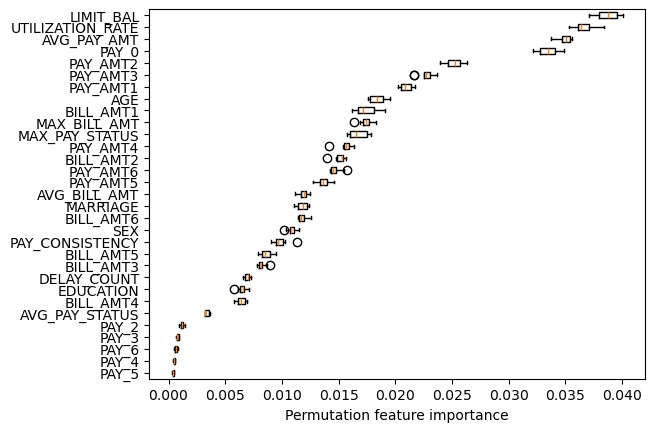

In [55]:
get_permutation_importance(rf_pipeline)

**Summary of Feature Importances**
Based on the permutation feature importance, these are top 4 most important features are:

- LIMIT_BAL (Credit Limit Balance), with an importance score of approximately 0.038.
  Clients with higher credit limits are generally less likely to default. A larger credit limit usually reflects financial stability and better credit credit history, which correlate with lower default risk.
- UTILIZATION_RATE with an importance score of ~0.036.
  A higher utilization rate indicates financial stress. Clients with a utilization rate are more likely to default, those with lower utilization rates tend to manage credit more responsibly.
- AVG_PAY_AMT (Average Payment Amount) with an importance score of ~0.034.
  Clients who consistently make higher payments are less likely to default, as this behavior shows the ability and willingness to pay off balances regularly. Low or irregular payments suggest higher default risk.
- PAY_0 (Most recent payment status) with an importance score of ~0.032. This variable represents whether the most recent payment was made on time or delayed. A higher value (indicating late payments or missed payments) is strongly correlated with a higher default probability. In contrast, a low or zero value (on-time payments) reduces the risk prediction, signaling good credit behavior.

## Evaluation on the Test Set

In [56]:
svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)

In [57]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.2f}")

F1-Score: 0.80


In [58]:
y_pred = pd.DataFrame(y_pred).reset_index(drop=True)
combined_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), y_pred], axis = 1)
combined_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,AVG_BILL_AMT,AVG_PAY_AMT,UTILIZATION_RATE,MAX_BILL_AMT,AVG_PAY_STATUS,MAX_PAY_STATUS,DELAY_COUNT,PAY_CONSISTENCY,default.payment.next.month,0
0,40000.0,2,2,2,26,-1,0,0,0,-1,...,21617.166667,5892.166667,0.540416,44024.0,-0.333333,0,0,0.516398,0,0
1,80000.0,2,3,1,59,0,0,0,0,0,...,58270.166667,2138.333333,0.728368,75662.0,0.000000,0,0,0.000000,0,0
2,170000.0,2,1,2,30,2,2,2,2,2,...,162134.833333,5466.666667,0.953729,170922.0,2.000000,2,6,0.000000,1,1
3,200000.0,2,2,1,41,-2,-2,-2,-2,-2,...,4050.833333,123.666667,0.020254,23570.0,-2.000000,-2,0,0.000000,1,0
4,50000.0,1,2,1,43,0,0,0,0,0,...,8925.166667,608.000000,0.178500,9617.0,0.000000,0,0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,60000.0,2,2,1,48,0,0,0,0,0,...,39950.666667,1350.000000,0.665833,51874.0,0.000000,0,0,0.000000,1,0
8996,310000.0,1,2,1,43,-1,-1,-1,-1,-1,...,2502.500000,2190.333333,0.008073,4943.0,-1.000000,-1,0,0.000000,0,0
8997,10000.0,2,2,2,22,0,0,0,0,0,...,8336.833333,1017.000000,0.833600,10104.0,0.333333,2,1,0.816497,0,0
8998,30000.0,1,2,1,38,1,-1,-1,-1,-1,...,1443.333333,1443.333333,0.048110,3666.0,-0.833333,1,1,0.983192,1,0


With the validation score being 0.82, and the testing score being 0.80, our model is fairly consistent, with a difference of less than 0.02 in the scores. We trust our results to a high regard as we are sure that there isn't any data leakage. As for optimization bias, according to our previous results in feature selection, our train and test scores showed no signs of underfitting nor overfitting.

When talking about individual predictions. We can take the first sample (first row) and see that LIMIT_BAL being rather in the intermediate range (40000) is a high contributor to the prediction being correct, along with other columns such as UTILIZATION_RATE being in the mid-range as well (0.54). Different with AVG_PAY_AMT which seems to be in the higher ranges (~5892).

## Conclusion

| Model | Validation Scores | Key Observations in Feature Selection |
|-------------|-------------|--|
| K-NN | 0.8110 | Was an okay option but lower test score compared to SVM RBF |
| SVM RBF | 0.8191 | Had the best test score |
| RandomForestClassifier | 0.8200 | Most likely to have overfitted |
| LogisticRegression | 0.8156 | May or may have not underfitted |

Our takeaways are as follows:
- Every step of the ML process has to be done carefully, especially when training and validating for each model, because there could be data leakage, etc.
- Not all processes can be used for all model. In other words, there is not a lot of model-agnostic processes, whether it be feature selection or interpretability.
- We have to figure out the most efficient processes in order to be able to reevaluate from the start. Understanding which built-in functions or data structures are best for a given problem was crucial throughout the whole project.

Future Improvements: When talking about performance, we could've tested more models, but given the limited time, even with 4 models, we weren't sure of the proper steps to take for each model, as they have their own set of functions that work well with a certain model. We could've done the feature selection part better as well, maybe finding an outcome that leads us to use feature importance. 

In terms of interpretability, we didn't have a lot of time to be sure of whether our steps for performing shap was correct or not. hence, we decided to switch to using permutation importance instead for efficiency. if we had more time to assess which processes work, we would have a more conclusive result and understand which features played a bigger role in the final predicition.

Final Results: \
Test Score of Best Model (SVM RBF): 0.80 \
Metric Used: F1-Score